In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
os.chdir('../')

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import random
from scipy.spatial.distance import cdist
from src.dataset import *
from src.concept_vectors import *
from src.util import *
from src.plots import *
from src.hierarchy import *
from src.metrics import *
from src.models import * 
from src.create_vectors import *
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics.pairwise import cosine_similarity
from copy import copy
from collections import defaultdict, Counter
import pickle
from sklearn.neural_network import MLPClassifier
import time
from sklearn.ensemble import RandomForestClassifier

2023-05-18 10:57:51.840373: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Dataset and Hierarchy Setup

In [4]:
dataset = CUB_Dataset()

In [5]:
attributes = dataset.get_attributes()

In [6]:
shapley_hierarchy = create_hierarchy(create_ward_hierarchy, load_shapley_vectors_simple,dataset,'',attributes,43)

In [7]:
label_hierarchy = create_hierarchy(create_ward_hierarchy, load_label_vectors_simple,dataset,'',attributes,43)

In [8]:
concept_group_map = defaultdict(list)
for i,concept_name in enumerate(attributes):
    group = concept_name[:concept_name.find("::")]
    concept_group_map[group].append(i)

In [9]:
all_groups = list(concept_group_map.keys())

In [10]:
train = pickle.load(open("dataset/{}/preprocessed/train.pkl".format(dataset.root_folder_name),"rb"))
val = pickle.load(open("dataset/{}/preprocessed/val.pkl".format(dataset.root_folder_name),"rb"))
test = pickle.load(open("dataset/{}/preprocessed/test.pkl".format(dataset.root_folder_name),"rb"))

In [11]:
len(train) + len(val) + len(test)

11788

In [12]:
train_paths = set([i['img_path'] for i in train])
val_paths = set([i['img_path'] for i in val])
test_paths = set([i['img_path'] for i in test])

In [13]:
val_paths.intersection(test_paths)

set()

In [ ]:
train_data = dataset.get_data()
num_columns = train_x.shape[1]

In [ ]:
def evaluate_knn(train_x,train_y,valid_x,valid_y):
    knn = KNeighborsClassifier(n_neighbors=5)
    knn.fit(train_x, train_y)
    return sum(knn.predict(valid_x) == valid_y)/len(valid_y)

## Similar Examples

In [14]:
def find_similar_examples(all_concepts,current_concept,dist_metric):    
    distances = cdist(np.atleast_2d(current_concept), all_concepts, metric=dist_metric)
    indices = np.argsort(distances.squeeze())[:5]
    
    return indices

In [15]:
def plot_closest_images(all_concepts,current_concept,concept_idx,dataset,dist_metric):
    class_names = dataset.class_names
    
    close_examples = find_similar_examples(all_concepts,current_concept,dist_metric)
    current_img_path = dataset.get_data(train=False)[concept_idx]['img_path']
    current_y_val = dataset.get_data(train=False)[concept_idx]['class_label']
        
    train_data = dataset.get_data()

    fig, axes = plt.subplots(1, 6, figsize=(15, 3))
    
    for i, ax in enumerate(axes):
        if i == 0:
            ax.set_title("Ref: {}".format(class_names[current_y_val].split(".")[1].replace("_"," ")),fontsize=20)
            image = Image.open('dataset/'+current_img_path).resize((64,64))
            ax.imshow(image)
            ax.axis('off')
        else:
            j = close_examples[i-1]
            ax.set_title("{}".format(class_names[train_data[j]['class_label']].split(".")[1].replace("_"," ")),fontsize=20)
            image = Image.open('dataset/'+train_data[j]['img_path']).resize((64,64))
            ax.imshow(image)
            ax.axis('off')

    plt.tight_layout()    

In [16]:
def get_new_vals(intervention_idxs,related_concepts,c,true_c=None):
    new_c = copy(c)
    
    if true_c is None:
        true_c = copy(c)
    else:
        for concept_idx in intervention_idxs:
            new_c[concept_idx] = true_c[concept_idx]

    for concept_idx in range(len(new_c)):
        if concept_idx in intervention_idxs:
            continue
        
        full_prob = 0
        num_divide = 0
        
        for reference_concept in related_concepts[concept_idx]:
            if reference_concept in intervention_idxs:
                num_divide += 1
                function, confidence = related_concepts[concept_idx][reference_concept]
                true_concept_value = true_c[reference_concept]
                
                full_prob += confidence*function(true_c[reference_concept]) + (1-confidence)*c[concept_idx]
                
        if num_divide > 0:
            full_prob /= num_divide
            new_c[concept_idx] = full_prob
            
    return new_c

In [17]:
def find_closest_vectors(matrix,num_indices=10):
    num_vectors = matrix.shape[0]
    sim_matrix = cosine_similarity(matrix)

    # Set diagonal to -inf to exclude self-similarity
    np.fill_diagonal(sim_matrix, -np.inf)

    closest_indices = []
    for i in range(num_vectors):
        cosine_similarities = sim_matrix[i]
        distances = [(j, abs(sim),sim) for j, sim in enumerate(cosine_similarities)]
        # Sort by distance in descending order
        distances.sort(key=lambda x: x[1], reverse=True)
        # Get the indices of the 3 closest vectors (excluding itself)
        closest_indices.append([(j, sim) for j, d, sim in distances if j != i][:num_indices])

    return closest_indices

In [18]:
def get_related_scores(embedding_matrix,power=0,num_indices=10):
    closest_vectors = find_closest_vectors(embedding_matrix,num_indices=num_indices)
    related_concept2vec = {}
    identity_function = lambda s: s
    opposite_function = lambda s: 1-s
    
    n_concepts = num_columns

    for i in range(n_concepts):
        related_concept2vec[i] = {}

        for index,similarity in closest_vectors[i]:
            confidence = abs(similarity)**power
            if similarity > 0:
                related_concept2vec[i][index] = (identity_function,confidence)
            else:
                related_concept2vec[i][index] = (opposite_function,confidence)
                
    return related_concept2vec

In [20]:
train_x = np.array([i['attribute_label'] for i in dataset.get_data()])
train_logits = np.load("results/logits/{}/train_c.npy".format(dataset.experiment_name)) 
train_y = np.array([i['class_label'] for i in pickle.load(open("dataset/{}/preprocessed/train.pkl".format(dataset.root_folder_name),"rb"))])

valid_x = np.array([i['attribute_label'] for i in pickle.load(open("dataset/{}/preprocessed/val.pkl".format(dataset.root_folder_name),"rb"))])
valid_logits = np.load("results/logits/{}/valid_c.npy".format(dataset.experiment_name))
valid_y = np.array([i['class_label'] for i in pickle.load(open("dataset/{}/preprocessed/val.pkl".format(dataset.root_folder_name),"rb"))])

test_x = np.array([i['attribute_label'] for i in pickle.load(open("dataset/{}/preprocessed/test.pkl".format(dataset.root_folder_name),"rb"))])
test_logits = np.load("results/logits/{}/test_c.npy".format(dataset.experiment_name))
test_y = np.array([i['class_label'] for i in pickle.load(open("dataset/{}/preprocessed/test.pkl".format(dataset.root_folder_name),"rb"))])

In [21]:
def dist(x, y, indices):
    diff = np.abs(x-y)*indices
    return np.mean(diff)

In [23]:
def traverse_hierarchy(hierarchy):
    all_groups = []
    if hierarchy.left_split.leaf or hierarchy.right_split.leaf:
        all_groups.append(hierarchy.value)
    else:
        all_groups += traverse_hierarchy(hierarchy.left_split)
        all_groups += traverse_hierarchy(hierarchy.right_split)
    
    return all_groups 

def groups_to_indices(groups):
    indices = [[dataset.get_attributes().index(j) for j in i] for i in groups]
    num_attributes = sum([len(i) for i in indices])
    
    ret = [1 for i in range(num_attributes)]
    
    for i in indices:
        for j in i:
            ret[j] = 1/len(i)
            
    return np.array(ret)

In [24]:
groups_shapley = traverse_hierarchy(shapley_hierarchy.root_split)
indices_shapley = groups_to_indices(groups_shapley)

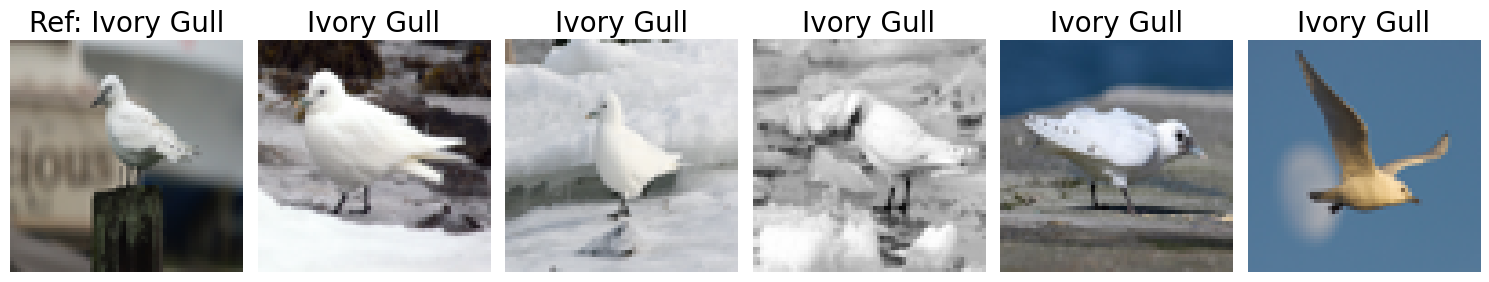

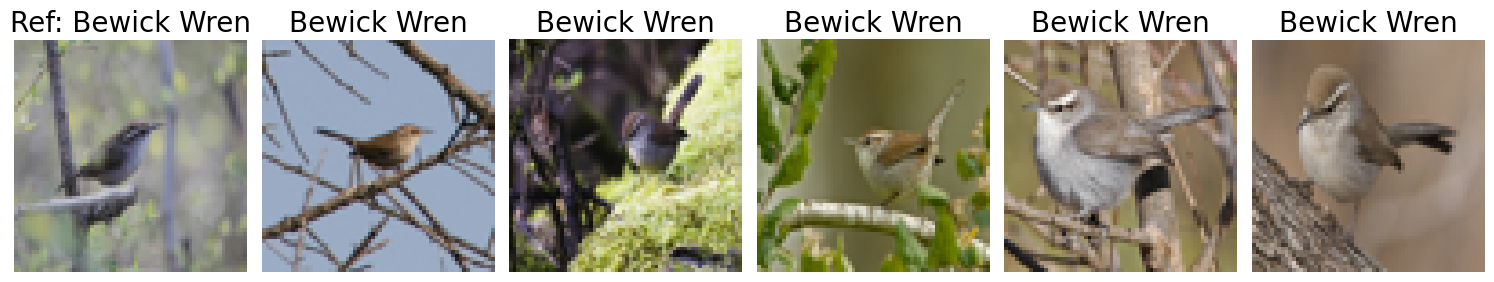

In [25]:
example_idx = 0
plot_closest_images(train_logits,valid_logits[example_idx],example_idx,dataset,lambda x,y: dist(x,y,indices_shapley))
plt.savefig("./scripts/Figures/close_birds_1.pdf",bbox_inches="tight")
plot_closest_images(train_logits,valid_logits[example_idx+4],example_idx+4,dataset,lambda x,y: dist(x,y,indices_shapley))
plt.savefig("./scripts/Figures/close_birds_2.pdf",bbox_inches="tight")

In [79]:
closest_images_y = np.zeros(closest_images.shape)
for i in range(len(closest_images_y)):
    for j in range(len(closest_images_y[0])):
        closest_images_y[i][j] = train_data[closest_images[i][j]]['class_label']

In [80]:
real_images_y = np.zeros(real_images.shape)
for i in range(len(real_images_y)):
    for j in range(len(real_images_y[0])):
        real_images_y[i][j] = train_data[real_images[i][j]]['class_label']

In [81]:
np.sum(real_images_y == closest_images_y)/(real_images_y.size)

0.7561960648947187

In [62]:
find_similar_examples(train_logits,test_logits[0],lambda x,y: dist(x,y,indices_shapley))

array([   5,  219,  640, 3124, 1388])

## Fixing Classification Errors + Training a KNN

In [29]:
acc_by_col = [sum(np.round(train_logits[:,i]) == train_x[:,i])/len(train_logits[:,i]) for i in range(num_columns)]
best_indices = list(np.argsort(acc_by_col)[::-1])

In [24]:
valid_concept_acc = np.sum(np.round(valid_logits) == valid_x)/(valid_x.shape[0]*valid_x.shape[1])
valid_concept_acc

0.7022222222222222

In [25]:
test_concept_acc = np.sum(np.round(test_logits) == test_x)/(test_x.shape[0]*test_x.shape[1])
test_concept_acc

0.7004444444444444

In [27]:
def acc(pred,true):
    pred = np.array(pred)
    true = np.array(true)
    return np.sum(pred == true)/true.size

In [ ]:
acc(np.round(train_logits), train_x), acc(np.round(valid_logits), valid_x), acc(np.round(test_logits), test_x), 

In [28]:
new_relations_0 = {}
new_relations_1 = {}

In [29]:
for i in range(num_columns):
    # See what makes this 0
    all_nums = []
    
    for j in range(num_columns):
        if i != j:
            times_when_i_0 = 1-train_x[:,i]
            times_when_j_0 = 1-train_x[:,j]
            total_i_0 = len((times_when_i_0).nonzero()[0])
            total_j_0 = len((times_when_j_0).nonzero()[0])
            frac_times = len(((times_when_i_0)*(times_when_j_0)).nonzero()[0])
            
            if total_j_0 != 0:
                frac_times /= total_j_0
            else:
                frac_times = 0
            all_nums.append((j,frac_times))
            
    new_relations_0[i] = sorted(all_nums,key=lambda k: k[1],reverse=True)[:5]

In [30]:
for i in range(num_columns):
    # See what makes this 0
    all_nums = []
    
    for j in range(num_columns):
        if i != j:
            times_when_i_1 = train_x[:,i]
            times_when_j_1 = train_x[:,j]
            total_i_1 = len((times_when_i_1).nonzero()[0])
            total_j_1 = len((times_when_j_1).nonzero()[0])
            frac_times = len(((times_when_i_1)*(times_when_j_1)).nonzero()[0])
            
            if total_j_1 != 0:
                frac_times /= total_j_1
            else:
                frac_times = 0
            all_nums.append((j,frac_times))
            
    new_relations_1[i] = sorted(all_nums,key=lambda k: k[1],reverse=True)[:5]

In [31]:
def row_to_fix(logits):
    x_vals = []
    
    for i in range(len(logits)):
        logit_value = logits[i]
        similar_0 = new_relations_0[i]
        similar_probs = [k[1] for k in similar_0]
        similar_0_logits = [logits[k[0]] for k in similar_0]
        
        
        similar_1 = new_relations_1[i]
        similar_probs_1 = [k[1] for k in similar_1]
        similar_1_logits = [logits[k[0]] for k in similar_1]
        
        temp = [logit_value]
        temp += similar_probs
        temp += similar_0_logits
        temp += similar_probs_1
        temp += similar_1_logits
                
        x_vals.append(temp)
        
    return x_vals

def row_to_fix_2(logits):
    x_vals = []
    
    for i in range(len(logits)):
        logit_value = logits[i]
        similar_0 = new_relations_0[i]
        similar_probs = [k[1] for k in similar_0]
        similar_0_logits = [logits[k[0]] for k in similar_0]
        
        
        similar_1 = new_relations_1[i]
        similar_probs_1 = [k[1] for k in similar_1]
        similar_1_logits = [logits[k[0]] for k in similar_1]
        
        temp = [logit_value]
        temp += similar_probs
        temp += similar_0_logits
        temp += similar_probs_1
        temp += similar_1_logits
                
        x_vals.append(temp)
        
    return x_vals

In [ ]:
embedding_matrix = np.array([load_shapley_vectors_simple(a,dataset,"",43)[0] for a in dataset.get_attributes()]) #np.load(open("results/temp/labels_43.npy","rb"))
sim_matrix = cosine_similarity(embedding_matrix)

In [32]:
def get_fix_data(logits,x,func=row_to_fix):
    fix = []
    y = []
    
    for row in logits:
        fix += func(row)
    
    for row in x:
        y += list(row)
    fix = np.array(fix)
    y = np.array(y)
    
    return fix, y

In [ ]:
train_fix_concept, train_fix_y = get_fix_data(train_logits,train_x,func=row_to_fix_2)
valid_fix_concept, valid_fix_y = get_fix_data(valid_logits,valid_x,func=row_to_fix_2)
test_fix_concept, test_fix_y = get_fix_data(test_logits,test_x,func=row_to_fix_2)

In [ ]:
clf_concept = MLPClassifier(max_iter=100)
start = time.time()
clf_concept.fit(train_fix_concept,train_fix_y)
print("Took {} time".format(time.time()-start))

In [ ]:
train_predict_concept_proba = clf_concept.predict_proba(train_fix_concept)[:,1].reshape(train_x.shape)
valid_predict_concept_proba = clf_concept.predict_proba(valid_fix_concept)[:,1].reshape(valid_x.shape)
test_predict_concept_proba = clf_concept.predict_proba(test_fix_concept)[:,1].reshape(test_x.shape)

In [44]:
evaluate_knn(train_logits,train_y,valid_logits,valid_y)

0.6786310517529215

In [45]:
evaluate_knn(np.round(train_logits),train_y,np.round(valid_logits),valid_y)

0.6477462437395659

In [ ]:
evaluate_knn(train_predict_concept_proba,train_y,valid_predict_concept_proba,valid_y)

## Some modifications to this method

### Using a Random Forest

In [47]:
clf_rf = RandomForestClassifier()

In [48]:
start = time.time()
clf_rf.fit(train_fix,train_fix_y)
print("Took {} time".format(time.time()-start))

Took 303.15066361427307 time


In [49]:
train_predict_rf = clf_rf.predict(train_fix).reshape(train_x.shape)
valid_predict_rf = clf_rf.predict(valid_fix).reshape(valid_x.shape)
test_predict_rf = clf_rf.predict(test_fix).reshape(test_x.shape)

In [47]:
acc(train_predict_rf, train_x), acc(valid_predict_rf, valid_x), acc(test_predict_rf, test_x)

(1.0, 0.8876296296296297, 0.8899259259259259)

In [48]:
evaluate_knn(train_predict_rf,train_y,valid_predict_rf,valid_y)

0.644

In [49]:
train_predict_rf_proba = clf_rf.predict_proba(train_fix)[:,1].reshape(train_x.shape)
valid_predict_rf_proba = clf_rf.predict_proba(valid_fix)[:,1].reshape(valid_x.shape)
test_predict_rf_proba = clf_rf.predict_proba(test_fix)[:,1].reshape(test_x.shape)

In [50]:
evaluate_knn(train_predict_rf_proba,train_y,valid_predict_rf_proba,valid_y)

0.6813333333333333

### Use Only the Logits

In [81]:
clf_trimmed = MLPClassifier(max_iter=100)

In [82]:
start = time.time()
clf_trimmed.fit(train_fix[:,:1],train_fix_y)
print("Took {} time".format(time.time()-start))

Took 95.71928715705872 time


/auto/homes/njr61/environments/mambaforge/envs/concepts/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


In [83]:
train_predict_trimmed = clf_trimmed.predict(train_fix[:,:1]).reshape(train_x.shape)
valid_predict_trimmed = clf_trimmed.predict(valid_fix[:,:1]).reshape(valid_x.shape)
test_predict_trimmed = clf_trimmed.predict(test_fix[:,:1]).reshape(test_x.shape)

In [84]:
acc(train_predict_trimmed, train_x), acc(valid_predict_trimmed, valid_x), acc(test_predict_trimmed, test_x)

(0.7588222222222222, 0.7575555555555555, 0.7579259259259259)

In [85]:
evaluate_knn(train_predict_trimmed,train_y,valid_predict_trimmed,valid_y)

0.35333333333333333

### Test set

In [50]:
evaluate_knn(train_logits,train_y,test_logits,test_y)

0.6731101139109423

In [51]:
evaluate_knn(np.round(train_logits),train_y,np.round(test_logits),test_y)

0.6280635139799793

In [54]:
evaluate_knn(train_predict_rf,train_y,test_predict_rf,test_y)

0.6556782878840179

In [55]:
evaluate_knn(np.round(train_predict_rf),train_y,np.round(test_predict_rf),test_y)

0.6556782878840179

In [92]:
evaluate_knn(train_predict_concept_proba,train_y,test_predict_concept_proba,test_y)

0.58

In [94]:
evaluate_knn(train_predict_trimmed,train_y,test_predict_trimmed,test_y)

0.36

## Running for multiple trials

In [41]:
eval_baseline = []
eval_baseline_round = []
for i in range(3):
    np.random.seed(i+43)
    eval_baseline.append(evaluate_knn(train_logits,train_y,test_logits,test_y))
    eval_baseline_round.append(evaluate_knn(np.round(train_logits),train_y,np.round(test_logits),test_y))

In [42]:
eval_baseline, eval_baseline_round

([0.6731101139109423, 0.6731101139109423, 0.6731101139109423],
 [0.6280635139799793, 0.6280635139799793, 0.6280635139799793])

In [43]:
np.mean(eval_baseline), np.std(eval_baseline),np.mean(eval_baseline_round),np.std(eval_baseline_round)

(0.6731101139109423, 0.0, 0.6280635139799793, 0.0)

In [44]:
eval_ours = []
eval_ours_round = []
for i in range(3):
    np.random.seed(i+43)
    print("On {}".format(i))
    embedding_matrix = np.array([load_label_vectors_simple(a,dataset,"",43)[0] for a in dataset.get_attributes()])
    sim_matrix = cosine_similarity(embedding_matrix)
    clf_concept = MLPClassifier(max_iter=100)
    
    train_fix_concept, train_fix_y = get_fix_data(train_logits,train_x,func=row_to_fix_2)
    valid_fix_concept, valid_fix_y = get_fix_data(valid_logits,valid_x,func=row_to_fix_2)
    test_fix_concept, test_fix_y = get_fix_data(test_logits,test_x,func=row_to_fix_2)
    
    clf_concept.fit(train_fix_concept,train_fix_y)
    train_predict_concept_proba = clf_concept.predict_proba(train_fix_concept)[:,1].reshape(train_x.shape)
    valid_predict_concept_proba = clf_concept.predict_proba(valid_fix_concept)[:,1].reshape(valid_x.shape)
    test_predict_concept_proba = clf_concept.predict_proba(test_fix_concept)[:,1].reshape(test_x.shape)
    eval_ours.append(evaluate_knn(train_predict_concept_proba,train_y,test_predict_concept_proba,test_y))
    eval_ours_round.append(evaluate_knn(np.round(train_predict_concept_proba),train_y,np.round(test_predict_concept_proba),test_y))

On 0
On 1
On 2


In [45]:
eval_ours, eval_ours_round

([0.6762167759751467, 0.6824301001035554, 0.6781152916810493],
 [0.6534345875043148, 0.6556782878840179, 0.6511908871246117])

In [46]:
np.mean(eval_ours), np.std(eval_ours),np.mean(eval_ours_round),np.std(eval_ours_round)

(0.6789207225865838,
 0.002599729266527446,
 0.6534345875043148,
 0.0018319736886538362)

In [49]:
eval_rf = []
eval_rf_round = []
for i in range(3):
    np.random.seed(i+43)
    print("On {}".format(i))
    embedding_matrix = np.array([load_label_vectors_simple(a,dataset,"",43)[0] for a in dataset.get_attributes()])
    sim_matrix = cosine_similarity(embedding_matrix)
    clf_concept = RandomForestClassifier()
    
    train_fix_concept, train_fix_y = get_fix_data(train_logits,train_x,func=row_to_fix_2)
    valid_fix_concept, valid_fix_y = get_fix_data(valid_logits,valid_x,func=row_to_fix_2)
    test_fix_concept, test_fix_y = get_fix_data(test_logits,test_x,func=row_to_fix_2)
    
    clf_concept.fit(train_fix_concept,train_fix_y)
    train_predict_concept_proba = clf_concept.predict_proba(train_fix_concept)[:,1].reshape(train_x.shape)
    valid_predict_concept_proba = clf_concept.predict_proba(valid_fix_concept)[:,1].reshape(valid_x.shape)
    test_predict_concept_proba = clf_concept.predict_proba(test_fix_concept)[:,1].reshape(test_x.shape)
    eval_rf.append(evaluate_knn(train_predict_concept_proba,train_y,test_predict_concept_proba,test_y))
    eval_rf_round.append(evaluate_knn(np.round(train_predict_concept_proba),train_y,np.round(test_predict_concept_proba),test_y))

On 0
On 1
On 2


In [50]:
eval_rf, eval_rf_round

([0.6767345529858474, 0.6772523299965482, 0.6788056610286504],
 [0.6527442181567138, 0.6506731101139109, 0.6582671729375216])

In [51]:
np.mean(eval_rf), np.std(eval_rf),np.mean(eval_rf_round),np.std(eval_rf_round)

(0.6775975146703486,
 0.0008800516937509391,
 0.6538948337360487,
 0.0032052441093508573)

### Write the predict probabilities as the new training dataset; see how MLPs do

In [121]:
np.save(open("results/logits/{}/train_c_fixed.npy".format(dataset.experiment_name),"wb"),train_predict_concept_proba)

In [122]:
np.save(open("results/logits/{}/valid_c_fixed.npy".format(dataset.experiment_name),"wb"),valid_predict_concept_proba)

In [123]:
np.save(open("results/logits/{}/test_c_fixed.npy".format(dataset.experiment_name),"wb"),test_predict_concept_proba)